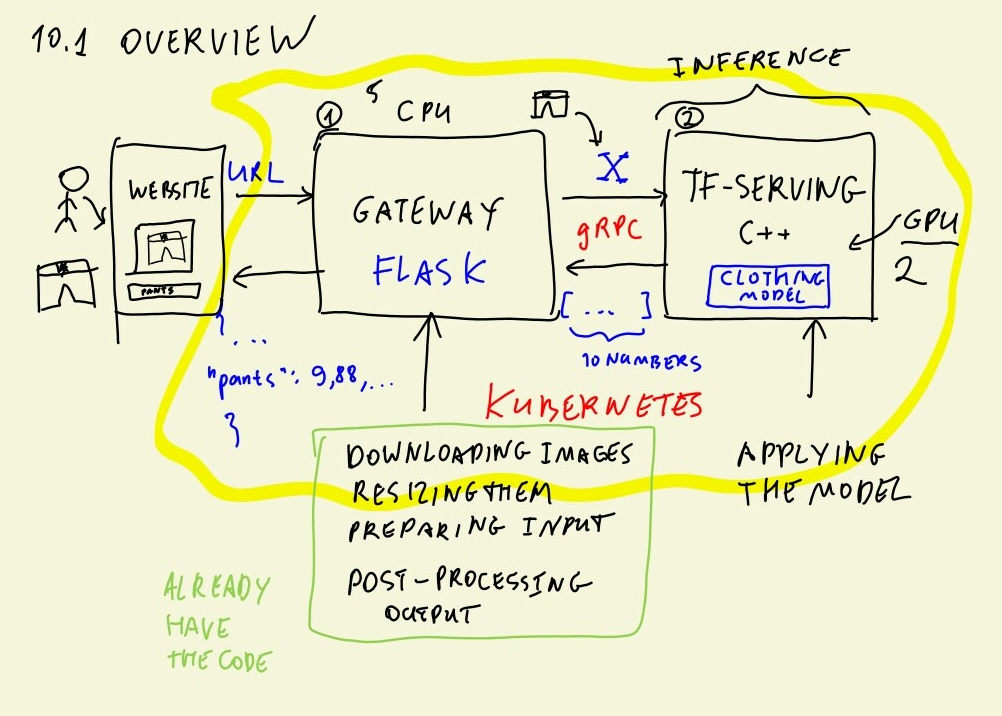

## Steps for our model:
1. Import keras from tensorflow (as tf)
2. Load our model
3. Save our model as a folder using `tf.saved_model.save()`
- e.g. `tf.saved_model.save(model, 'model-name')` where model-name can be changed (i.e. 'clothing-model')
4. In our command line, we can use `ls -lhR model-name` to check the contents of our folder
- Make sure that there is a saved_model.pb file in there, alongside an 'assets' folder and a 'variables' folder
- The 'variables' folder should include variables.data-00000-of-00001 and variables.index
5. Type in command line `saved_model_cli show --dir model-name --all` and get the inputs and outputs from the saved_model
- i.e. inputs and outputs under `signature_def['serving_default']`

## Docker Command

docker run -it --rm 

-p 8500:8500 --> port

-v "$(pwd)/clothing-model:/models/clothing-model/1" --> Volume Mounting

-e MODEL_NAME="clothing-model" --> Environmental Variable (the clothing model, should match the one in volume mounting)

tensorflow/serving:2.7.0 --> Image Name

In [ ]:
!pip install grpcio==1.42.0 tensorflow-serving-api==2.7.0

In [ ]:
!pip install keras-image-helper

In [11]:
import grpc 

import tensorflow as tf

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [12]:
# From the initialization of Docker 
host = 'localhost:8500'

# We use an insecure channel because we are running this locally 
channel = grpc.insecure_channel(host)

# Stub used to make predictions 
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

In [13]:
from keras_image_helper import create_preprocessor 

In [14]:
preprocessor = create_preprocessor('xception', target_size = (299,299))

In [15]:
url = 'http://bit.ly/mlbookcamp-pants'
X = preprocessor.from_url(url)

In [16]:
def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape = data.shape)

In [17]:
pb_request = predict_pb2.PredictRequest()

pb_request.model_spec.name = 'clothing-model'
pb_request.model_spec.signature_name = 'serving_default'

pb_request.inputs['input_8'].CopyFrom(np_to_protobuf(X))

In [18]:
pb_request

model_spec {
  name: "clothing-model"
  signature_name: "serving_default"
}
inputs {
  key: "input_8"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 299
      }
      dim {
        size: 299
      }
      dim {
        size: 3
      }
    }
    tensor_content: "\350\350\350\275\234\234\034\276\314\314L\276\350\350\350\275\234\234\034\276\314\314L\276\330\330\330\275\224\224\024\276\304\304D\276\270\270\270\275\204\204\004\276\264\2644\276\210\210\210\275\330\330\330\275\234\234\034\276\360\360p\275\310\310\310\275\224\224\024\276\260\2600\275\250\250\250\275\204\204\004\276\240\240\240\274\360\360p\275\330\330\330\275\300\300@\274\320\320P\275\310\310\310\275\000\201\200;\220\220\020\275\250\250\250\275\000\201\200;\220\220\020\275\250\250\250\275\000\201\200;\220\220\020\275\250\250\250\275\000\201\200;\220\220\020\275\360\360p\275\300\2600=\000\201\200;\240\240\240\274\220\210\210=\000\341\340<\000\201\200;\260\250\250=\

In [19]:
pb_response = stub.Predict(pb_request, timeout=20)

In [20]:
pb_response

outputs {
  key: "dense_7"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 10
      }
    }
    float_val: -1.8682903051376343
    float_val: -4.761245250701904
    float_val: -2.316983461380005
    float_val: -1.0625708103179932
    float_val: 9.887161254882812
    float_val: -2.8124334812164307
    float_val: -3.6662826538085938
    float_val: 3.200361728668213
    float_val: -2.6023378372192383
    float_val: -4.835046291351318
  }
}
model_spec {
  name: "clothing-model"
  version {
    value: 1
  }
  signature_name: "serving_default"
}

In [21]:
# For extraction of the outputs
preds = pb_response.outputs['dense_7'].float_val

In [22]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [23]:
dict(zip(classes, preds))

{'dress': -1.8682903051376343,
 'hat': -4.761245250701904,
 'longsleeve': -2.316983461380005,
 'outwear': -1.0625708103179932,
 'pants': 9.887161254882812,
 'shirt': -2.8124334812164307,
 'shoes': -3.6662826538085938,
 'shorts': 3.200361728668213,
 'skirt': -2.6023378372192383,
 't-shirt': -4.835046291351318}

## To build and run commands

docker build -t zoomcamp-10-model:xception-v4-001 -f image-model.dockerfile .

docker run -it --rm -p 8500:8500 zoomcamp-10-model:xception-v4-001

## To build and run gateways

docker build -t zoomcamp-10-gateway:001 -f image-gateway.dockerfile .

docker run -it --rm -p 9696:9696 zoomcamp-10-gateway:001

Create the docker-compose.yaml for docker-compose, so that there is a connection between the Flask app and TF-Serving.
docker-compose up for the cluster.

## Kubernetes notes:
We use Kubernetes to deploy Docker containers, it will manage and scale up when there is an increase in load and decrease when there is a need to.
It is all in Cloud 

Cluster contains everything that we need for deploying the model itself. However, we need an entrypoint.
The entrypoint to the cluster itself is the ingress.

Inside each cluster, we have nodes.
Node is like a server, or a Computer (e.g. EC2 instance)

Inside a node, we have pods. 
A pod is like a docker container. They can take different amount of resources. Some may take lesser CPU resources than others.
If there is an increased load, Kubernetes allows us to increase the number of pods there are (as well as a min and max value to the number of pods) This is called an Horizonal Pod Autoscaler (HPA).

We group the pods in deployments.
Deployments are a group of pods with the same image and configuration.
e.g. GATEWAY & TF-Serving deployments --> The deployments have the same image & configuration.

A service is the main entrypoint to our deployments which routes requests to pods. 
The services are responsible for routing the requests. There are external and internal services.
External services can be visible and can be used by clients outside of the cluster, while internal services cannot. 

There are certain terms that you probably will not touch, but since it's Kubernetes you will come by it anyway. 

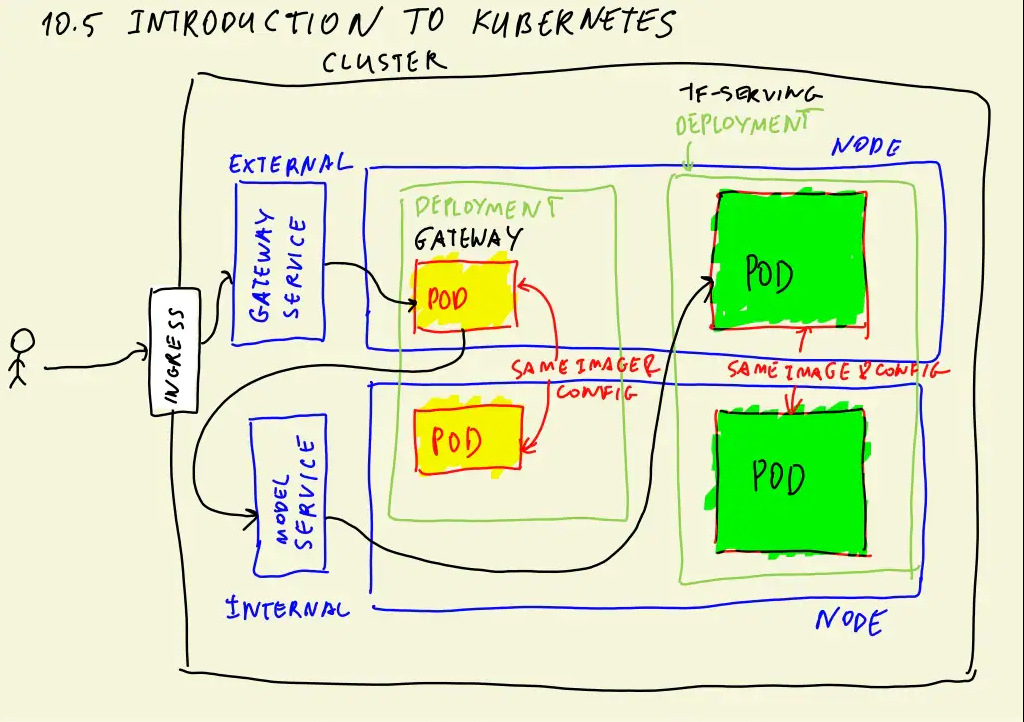